In [2]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
import numpy as np
import pandas as pd
from sklearn.cluster import k_means, kmeans_plusplus, KMeans
from sklearn.decomposition import PCA
import math
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch

# Assignment 3 - Clustering

For this assignment you'll need to use some clustering knowledge to build a function that can generate handwritten numbers from a provided number. 

The modelling parts of this assignment are not very complex, the application of the clustering algorithms is very similar to the examples from class. This will require a little more manipulation of data, and building a little bit of structure around the models, that's where some of the challenge lies. 

## Requirements
<ul>
<li>Use clustering to take the X data (the features/pixels) of the MNIST dataset, and group it into clusters. 
    <ul>
    <li>Do not use the targets from the dataset at all. 
    </ul>
<li>Assign labels to your clusters, so there is now a label for each cluster. You'll need to manually do a little mapping here by eye. 
<li>Use GMM to build a function that can generate a new digit from the information in the cluster. 
<li>Write a function, writeNumber, that can take in an integer (you can assume it is between 1 and 20 digits, this is mostly for printing purposes, the modelling part isn't impacted by this at all) and print out that integer as a generated handwritten number. 
<li><b>When generating the handwritten numbers, each version of a digit should be different. I.e. If the number printed is 22222, there should not be 5 identical 2s, they should vary a bit like real writing. </b>
</ul>

## Deliverables
Submit your .ipynb file to the Moodle dropbox. PLEASE make sure that the file runs BY ITSELF outside of importing libraries. It should not reference any other files, either data or code. 

Within your file, create a function called writeNumber, which takes a number as an input, and prints it out as a series of handwritten digits. The function should be callable like this, if I wanted to print the number 218201

~~~
writeNumber(218201)
~~~

This would produce something that looks, somewhat, like this:

![Writing Example](example.png "Writing Example" )

The exact appearance of the generated writing can vary, it likely won't be as well defined as this picture. As long as I can read it as a number, it is fine. 

Hint: the number of clusters may vary. 

## Grading
<ul>
<li> 70% - Code works. This is mostly a yes/no thing, if it doesn't work I'll try to see if it was a small or large issue in the code, but it largely works or it doesn't. 
<li> 20% - Numbers appearance. Is the writing OK? I'm not going to be overly picky, if they are reasonably legible, that is fine. 
<li> 10% - Code legibility. Is a quick read over of the code clear? Sections, comments, etc... 
</ul> 

## Load Data
<b> Please do not change this (substantially), probably outside of choosing between the full data and a subset. Don't load the target. </b>

Note: testing will be much faster with a subset of records. 

In [4]:
#Load Data
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
#mnist = mnist[0:15000]
df = mnist["data"]
print(df.shape)

(70000, 784)


## Cluster 

We need to break the data into clusters first... 

In [5]:
from sklearn.preprocessing import MinMaxScaler
X_clus = MinMaxScaler().fit_transform(df)
X_c = PCA(2).fit_transform(X_clus)

In [6]:
kmeans = KMeans(n_clusters=10)
kmeans.fit(X_c)
clusters = kmeans.predict(X_c)

labels

In [7]:
#LABELS 
#Initialize the class object
kmeans = KMeans(n_clusters= 10)
 
#predict the labels of clusters.
label = kmeans.fit_predict(X_c)
 
print(label)

[2 5 6 ... 6 7 5]


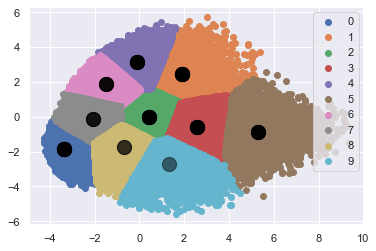

In [8]:
#Getting unique labels
 
u_labels = np.unique(label)
 
#plotting the results:
 
for i in u_labels:
    plt.scatter(X_c[label == i , 0] , X_c[label == i , 1] , label = i)
    centers = kmeans.cluster_centers_
    plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)
plt.legend()
plt.show()

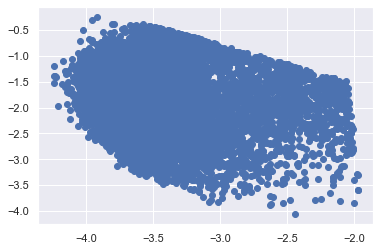

In [9]:
import matplotlib.pyplot as plt
 
#filter rows of original data
filtered_label0 = X_c[label == 0]
 
#plotting the results
plt.scatter(filtered_label0[:,0] , filtered_label0[:,1])
plt.show()

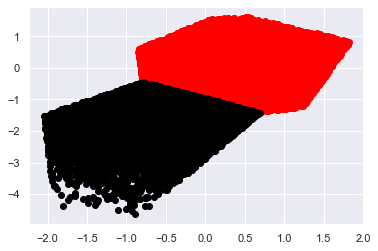

In [10]:
#filter rows of original data
filtered_label2 = X_c[label == 2]
 
filtered_label8 = X_c[label == 8]
 
#Plotting the results
plt.scatter(filtered_label2[:,0] , filtered_label2[:,1] , color = 'red')
plt.scatter(filtered_label8[:,0] , filtered_label8[:,1] , color = 'black')
plt.show()

old stuff

agg

In [12]:
#Look at an image
def showDigit(digit, label, size=70):
    some_digit = digit
    label = u_labels
    #turn array into the correct shape
    some_digit_image = np.array(some_digit).reshape(size, size)
    #imshow displays an array like an image
    plt.imshow(some_digit_image, cmap=mpl.cm.binary)
    plt.title(label)
    plt.axis("off")
    plt.show()

#Display multiple digits
def showDigits(digits, labels, indexes, size=28):
    #Make a grid that is the right size
    pics = len(indexes)
    labels = u_labels
    cols = 6
    rows = math.ceil(pics/cols)
    fig, axes = plt.subplots(rows, cols, figsize=(14,6))
    plt.axis("off")

    #loop through the list of indexes, grab images and labels, plot in the "next" spot. 
    for i in range(0, pics):
        n = indexes[i]
        some_digit = digits[n:n+1]
        some_digit_image = np.array(some_digit).reshape(size, size)
        ax = axes[i//cols, i%cols]
        ax.axis("off")
        ax.imshow(some_digit_image, cmap=mpl.cm.binary)
        ax.set_title('Ind: {} - Lbl: {}'.format(indexes[i], labels[n]))
    plt.tight_layout()
    plt.axis("off")
    plt.show()

ValueError: cannot reshape array of size 20 into shape (10,28,28)

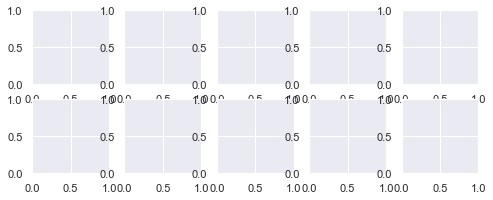

In [13]:
fig, ax = plt.subplots(2, 5, figsize=(8, 3))
centers = kmeans.cluster_centers_.reshape(10, 28, 28)
for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

<h2>GMM

In [14]:
# Some helper functions to plot from the book
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

In [17]:
from sklearn.decomposition import PCA
pca = PCA(0.99, whiten=True)
data = pca.fit_transform(X_c)
data.shape

(70000, 2)

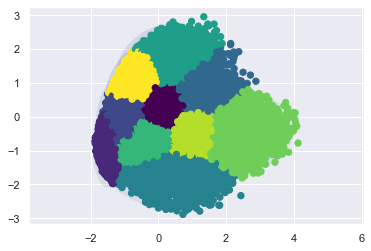

In [19]:
gmm = GaussianMixture(n_components=10).fit(data)
labels = gmm.predict(data)
#plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis')
plot_gmm(gmm, data)

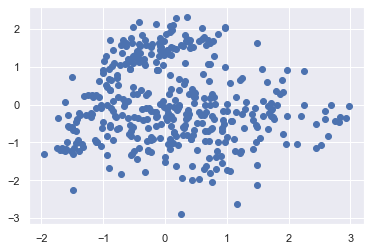

In [22]:
Xnew = gmm.sample(400)
plt.scatter(Xnew[0][:, 0], Xnew[0][:, 1])

In [ ]:
def WriteNumber(digits):
    digits = u_labels
